In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeRegressor

# Load the dataset
df = pd.read_csv('airbnb_sample_landmarks_zipcodes.csv')

### Data Cleaning

Check for missing data values

In [85]:
# check for missing values
df.isna().sum()

id                              0
last_scraped                    0
latitude                        0
longitude                       0
accommodates                    0
                             ... 
num_landmarks_dist_500m         0
closest_landmark                0
mean_log_dist_landmarks         0
median_log_dist_landmarks       0
zip_code                     2212
Length: 92, dtype: int64

Remove any instances with missing values. Drop transformed value columns and columns that will not be used in the model.

In [3]:
# drop missing values
df.dropna(inplace=True)
# remove all transformed variables from the dataframe
df = df.loc[:,~df.columns.str.contains('log')]
#drop unneeded columns
df = df.drop(columns=['id','last_scraped','latitude','longitude','borough'])

Convert categorical features to categorical data types and create dummy variables for each category.

In [4]:
df['closest_landmark'] = df['closest_landmark'].astype('category')
df['zip_code'] = df['zip_code'].astype('category')
# get dummies for the closet_landmark
df = pd.get_dummies(df)

Create train-test split data using 80% of instances for the training dataset and the remaining 20% for test dataset.

In [50]:
# train test split
xTrain, xTest, yTrain, yTest = train_test_split(df.drop(columns=['price']), df.price, test_size=0.2, random_state=42)

#### Random Forest Model

Instantiate a random forest regressor and run a 5-fold cross-validation on the model using both RSME and R-Squared scoring for the models.

In [51]:
rForest = RandomForestRegressor(random_state=42)
rForest_cv = cross_validate(rForest,xTrain,yTrain, cv = 5, scoring = ['neg_root_mean_squared_error','r2'])

In [52]:
print('------Random Forest------')
print(f'Mean R-Squared: {rForest_cv['test_r2'].mean()}   Standard Deviation of R-squared: {rForest_cv['test_r2'].std()}')
print(f'Mean RSME: {-rForest_cv['test_neg_root_mean_squared_error'].mean()}   Standard Deviation of RSME: {-rForest_cv['test_neg_root_mean_squared_error'].std()}')

------Random Forest------
Mean R-Squared: 0.26158165122022925   Standard Deviation of R-squared: 0.14906101660652765
Mean RSME: 340.9826379449663   Standard Deviation of RSME: -165.04810947976023


The large standard deviation in the test scores between each of the 5 folds indicates that the model maybe affected by outlier values or by overfitting.

#### Decision Tree Model

In [53]:
decisionTree = DecisionTreeRegressor(random_state=5280)
decisionTree_cv = cross_validate(decisionTree,xTrain,yTrain, cv = 5, scoring = ['neg_root_mean_squared_error','r2'])

In [54]:
print('------Decision Tree------')
print(f'Mean R-Squared: {decisionTree_cv['test_r2'].mean()}')
print(f'Mean RSME: {-decisionTree_cv['test_neg_root_mean_squared_error'].mean()}')

------Decision Tree------
Mean R-Squared: -2.0304076661673434
Mean RSME: 569.5276251842519


The random forest performed significantly better than the decision tree. As such we will advance the random forest model as the candidate model. The model will be compared to a model using training and test data with the outlier values replaced.

### Comparing Random Forest Without Outliers

Replace all values above the 99th percentile with the 99th percentile value.

In [5]:
# replace price greater than 5000 with 5000
q99 = df['price'].quantile(0.99)
df.loc[df['price'] > q99,'price'] = q99

Create updated train and test datasets

In [6]:
xTrain, xTest, yTrain, yTest = train_test_split(df.drop(columns=['price']), df.price, test_size=0.2, random_state=42)

Run cross-validation on the updated training dataset

In [59]:
rForest2_cv = cross_validate(rForest,xTrain,yTrain, cv = 5, scoring = ['neg_root_mean_squared_error','r2'])

In [60]:
print(f'Mean R-Squared: {rForest2_cv['test_r2'].mean()}   Standard Deviation of R-squared: {rForest2_cv['test_r2'].std()}')
print(f'Mean RSME: {-rForest2_cv['test_neg_root_mean_squared_error'].mean()}   Standard Deviation of RSME: {-rForest2_cv['test_neg_root_mean_squared_error'].std()}')

Mean R-Squared: 0.5948036528520566   Standard Deviation of R-squared: 0.007238908872412069
Mean RSME: 124.47083375343027   Standard Deviation of RSME: -5.620182691819652


The performance of the model was significantly improved with the replacement of the outlier values suggesting that the sample size may not have been large enough to overshadow the outliers. The training and test data without the outlier values will be used for tuning and assessing the model's performance.

### Hyper-parameter Tuning of the Random Forest Model

Try out 15 different models using random samples of hyperparameter settings for the max depth of the tree, the percentage of features to sample for each tree, and the number of trees to create in the forest.

In [62]:
params = {
    'max_depth':[5,10,15,20,25,30,35,40,45,50],
    'max_features':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
    'n_estimators': [50,100,150,200,250]
}

rForest_search = RandomizedSearchCV(rForest, n_iter=15, cv=5, scoring= 'neg_root_mean_squared_error', param_distributions= params, random_state=5820)
rForest_search.fit(xTrain,yTrain)

c:\Users\kmgth\Documents\Current Quarter\DS_Tools1\Airbnb Data\airbnb_env\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=15,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30, 35,
                                                      40, 45, 50],
                                        'max_features': [0.1, 0.2, 0.3, 0.4,
                                                         0.5, 0.6, 0.7, 0.8,
                                                         0.9, 1.0],
                                        'n_estimators': [50, 100, 150, 200,
                                                         250]},
                   random_state=5820, scoring='neg_root_mean_squared_error')

In [63]:
print(f'Best parameteres: {rForest_search.best_params_}')

Best parameteres: {'n_estimators': 200, 'max_features': 0.4, 'max_depth': 30}


### Training the Tuned Random Forest Model

Run a 5-fold cross validation on the random forest using the best parameters found from the RandomSearchCV and score the models using both RSME and R-Squared.

In [64]:
bestEstimator_cv = cross_validate(rForest_search.best_estimator_,xTrain,yTrain,cv=5,scoring = ['neg_root_mean_squared_error','r2'])

In [65]:
print(f'Mean R-Squared: {bestEstimator_cv['test_r2'].mean()}   Standard Deviation of R-Squared: {bestEstimator_cv['test_r2'].std()}')
print(f'Mean RSME: {-bestEstimator_cv['test_neg_root_mean_squared_error'].mean()}   Standard Deviation of RSME: {-bestEstimator_cv['test_neg_root_mean_squared_error'].std()}')


Mean R-Squared: 0.6114860462277996   Standard Deviation of R-Squared: 0.009945072981773098
Mean RSME: 121.91488869324971   Standard Deviation of RSME: -6.4111359188439625


### Assessing the Tuned Model

In [66]:
print(f'RSME: {root_mean_squared_error(yTest,rForest_search.predict(xTest))}')
print(f'R-Squared: {r2_score(yTest,rForest_search.predict(xTest))}')

RSME: 122.95328160769604
R-Squared: 0.62892801027011


The random forest model had an R-Squared value of 0.629 on the test data implying that performs better than random chance at predicting the daily listing price of an Airbnb rental in NYC. This was slighly higer than the R-Square score of 0.611 on the training data. However, the RSME did slightly increase for the testing data. Overall this implies that the model is mostly likely not overfitted to the training data and may generalize well.

Calculate the permuted feature importance for the tuned random forest model.

In [7]:
rForest2 = RandomForestRegressor(n_estimators=200,max_features=0.4,max_depth=30, random_state=5820)
rForest2.fit(xTrain,yTrain)

RandomForestRegressor(max_depth=30, max_features=0.4, n_estimators=200,
                      random_state=5820)

Run 10 permuations for the permuted feature importance.

In [8]:
perm_imp= \
permutation_importance(estimator= rForest2, 
                       n_repeats= 10, 
                       random_state=5820,
                       X= xTest,
                       y= yTest)

Display all permuted feature importance values for all features.

In [9]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
feat_imp=list(zip(xTrain.columns, perm_imp.importances_mean))
feat_imp.sort(key=lambda x: x[1], reverse=True)
feat_imp

[('bedrooms', np.float64(0.13216098038036322)),
 ('accommodates', np.float64(0.12927352514412793)),
 ('bathrooms_cleaned', np.float64(0.11871599437797717)),
 ('calculated_host_listings_count_entire_homes',
  np.float64(0.06961976250763705)),
 ('high_line_dist', np.float64(0.06656991568538803)),
 ('room_type_Private room', np.float64(0.04028804820271169)),
 ('minimum_nights', np.float64(0.04027379456640208)),
 ('whitney_museum_dist', np.float64(0.02458904880108237)),
 ('moma_ps1_dist', np.float64(0.023826578488010553)),
 ('room_type_Entire home/apt', np.float64(0.017905087525870167)),
 ('madison_square_garden_dist', np.float64(0.01480708234059338)),
 ('has_license', np.float64(0.013665277755055749)),
 ('calculated_host_listings_count_private_rooms',
  np.float64(0.01211969586604782)),
 ('empire_state_building_dist', np.float64(0.009596077976673967)),
 ('brooklyn_museum_dist', np.float64(0.009293601530632767)),
 ('instant_bookable', np.float64(0.005810124856209431)),
 ('chrysler_building

Based on the permuted feature importance values we can safely remove a large number of variables without significantly impacting the performance of the model.

In [10]:
temp = pd.DataFrame(feat_imp, columns=['Feature','Permuted_Importance'])
temp = temp[temp['Permuted_Importance']>= 0.001]
temp.sort_values(by=['Permuted_Importance'],inplace=True)

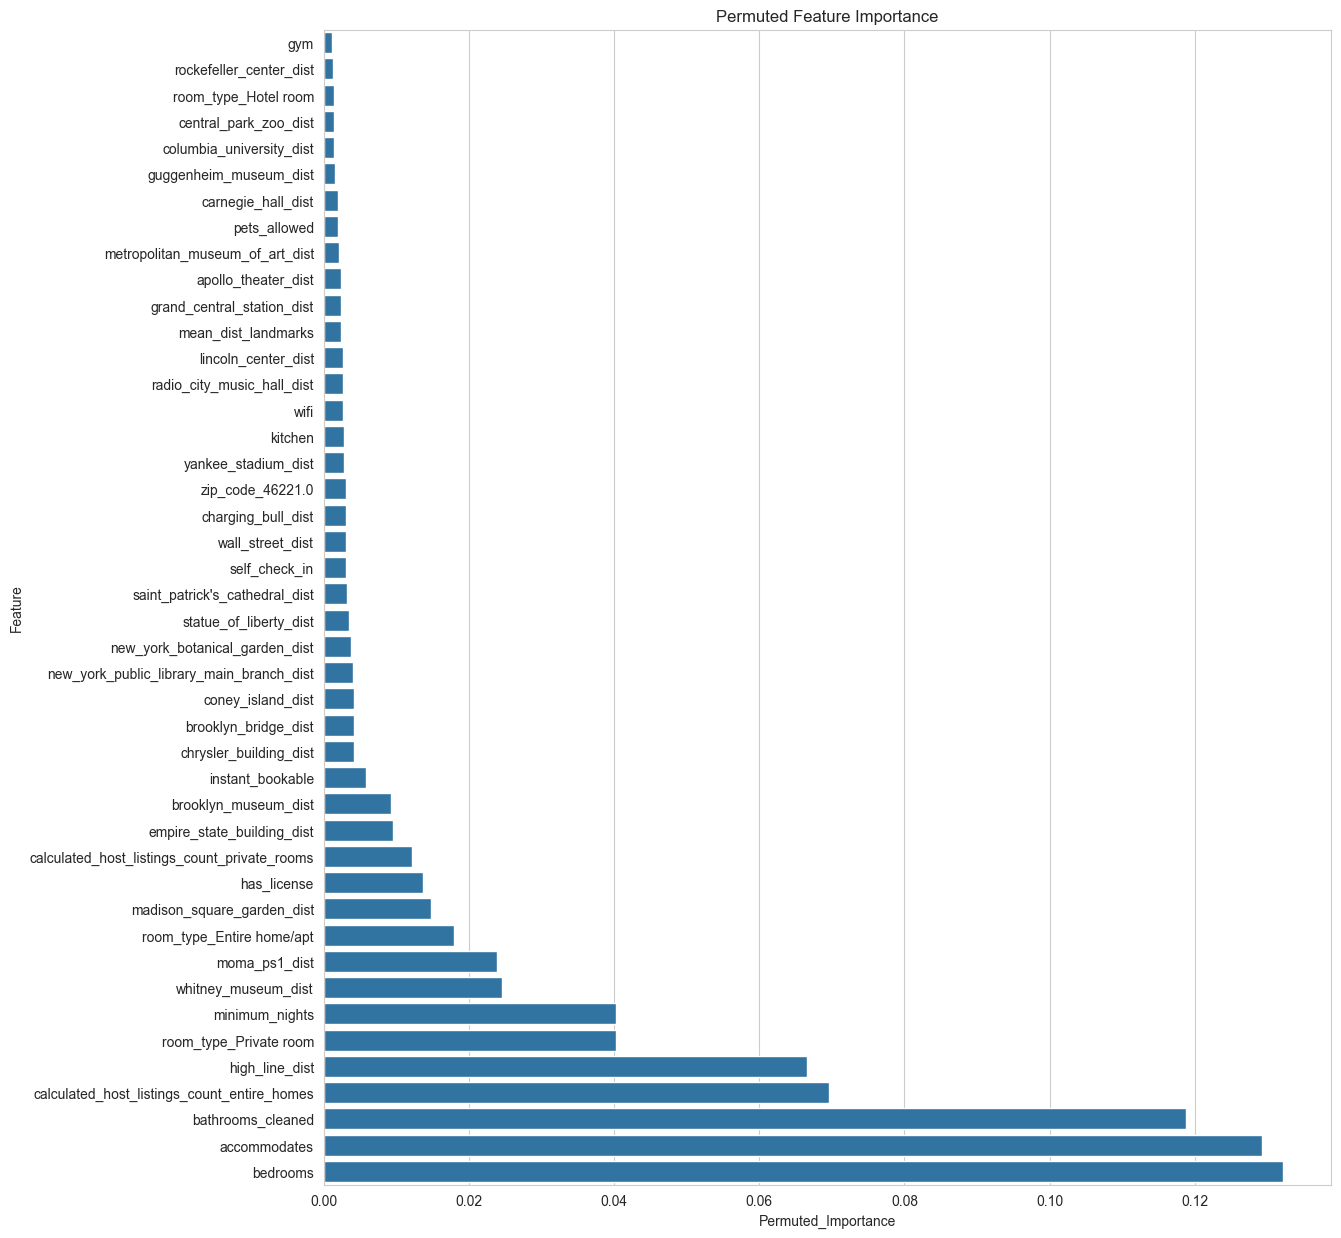

In [11]:
fig = plt.figure(figsize=(13,15))
sns.set_style('whitegrid')
sns.barplot(data=temp, x='Permuted_Importance', y='Feature', orient='h')
plt.title('Permuted Feature Importance')
plt.show()

Drop unimportant features for the model.

In [82]:
importFeatures = [
                'bedrooms', 'accommodates', 'bathrooms_cleaned', 
                'calculated_host_listings_count_entire_homes','high_line_dist', 
                'room_type_Private room', 'minimum_nights','whitney_museum_dist', 
                'moma_ps1_dist', 'room_type_Entire home/apt', 'madison_square_garden_dist', 
                'has_license', 'calculated_host_listings_count_private_rooms',
               'empire_state_building_dist', 'brooklyn_museum_dist', 'instant_bookable', 
                'coney_island_dist', 'new_york_public_library_main_branch_dist',
                'new_york_botanical_garden_dist', 'statue_of_liberty_dist', "saint_patrick's_cathedral_dist", 
                'self_check_in', 'wall_street_dist', 'charging_bull_dist','zip_code_46221.0', 
                'yankee_stadium_dist','kitchen', 'wifi', 'radio_city_music_hall_dist', 
                'lincoln_center_dist', 'mean_dist_landmarks', 'grand_central_station_dist', 
                'apollo_theater_dist', 'metropolitan_museum_of_art_dist', 'pets_allowed', 
                'carnegie_hall_dist', 'guggenheim_museum_dist', 'columbia_university_dist', 
                'central_park_zoo_dist', 'room_type_Hotel room', 'rockefeller_center_dist', 'gym'
]

In [83]:
xTrain2 = xTrain[importFeatures]
xTest2 = xTest[importFeatures]

Retrain the tuned model on the smaller group of features.

In [84]:
rforest3 = RandomForestRegressor(n_estimators=200,max_features=0.4,max_depth=30,random_state=5820)
rforest3.fit(xTrain2,yTrain)

RandomForestRegressor(max_depth=30, max_features=0.4, n_estimators=200,
                      random_state=5820)

Verify that the smaller number of features did not significantly impact the performance of the model.

In [85]:
print(f'RSME: {root_mean_squared_error(yTest,rforest3.predict(xTest2))}')
print(f'R-Squared: {r2_score(yTest,rforest3.predict(xTest2))}')

RSME: 122.42570534490137
R-Squared: 0.6321056198802492
